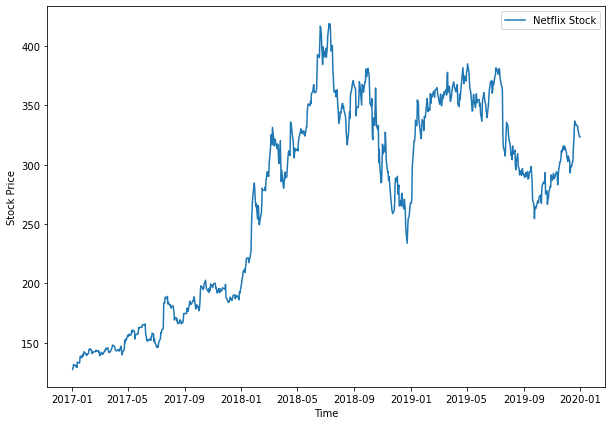

In [1]:
""" This is a stockprice prediction simulation using Geometric Brownian Motion and Monte Carlo"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas_datareader import data
from scipy import stats

start = '2017-01-01'
end   = '2020-01-01'

# Netflix ticker
ticker = 'NFLX' 

# Search the Netflix stock data
stock_data = data.DataReader(ticker, 'yahoo', start, end) 

closing_data = stock_data.Close

plt.figure(figsize=(10,7))
plt.plot(closing_data)
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend(["Netflix Stock"])
plt.show()

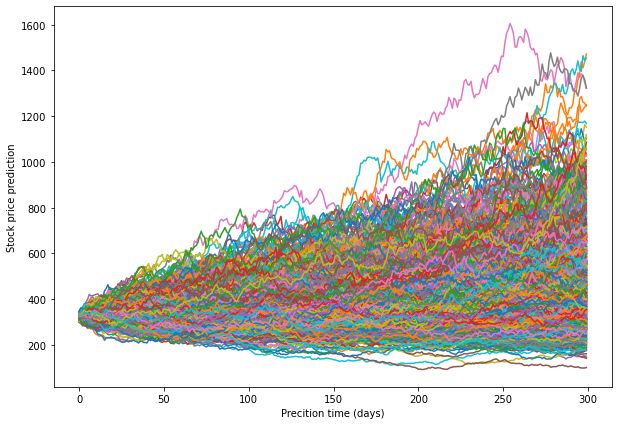

In [5]:
# Geometric Brownian Motion

np.random.seed(24)

price_returns = closing_data.pct_change()

predictions = pd.DataFrame()
returns_ = pd.DataFrame()

iterations = 1000
timespan = 300 # trading days

for i in range(iterations):
    S0 = closing_data[-1]     # last price of Netflix stock
    std = price_returns.std() # standard deviation of returns
    mu = price_returns.mean() # expected return
    
    pred = []
    diff = mu * S0 + S0 * np.random.normal(0,1) * std 
    value = S0 + diff
    pred.append(value)
    
    for j in range(timespan-1):
        diff = mu * pred[-1] + pred[-1] * np.random.normal(0,1) * std
        value = pred[-1] + diff
        pred.append(value)
    
    predictions[i] = pred
    
    
plt.figure(figsize=(10,7))
plt.plot(predictions)
plt.xlabel("Precition time (days)")
plt.ylabel("Stock price prediction")
plt.show()


Information about the fitted lognormal distribution:

The mean of the distribution is 499 $.
The mode of the distribution is 396 $.
The median of the distribution is 466 $.
The variance of the distribution is 41807 $.
The standard deviation of the distribution is 204 $.

Value at risk: at 95% confidence the closing stock will be greater than  240 $.



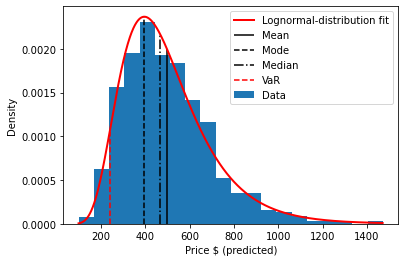

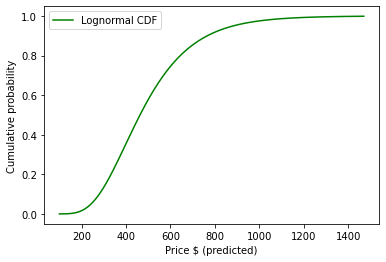

In [16]:
# Result analysis => Prices

last_prices = predictions.tail(1).to_numpy()[0]              # last trading day prices
      
xmin, xmax = int(last_prices.min()) , int(last_prices.max()) # Search min and max values from data
span = np.arange(xmin, xmax) 

shape, loc, scale = stats.lognorm.fit(last_prices, floc=0) # fit the lognormal distribution to data

pdf = stats.lognorm.pdf(span, shape, loc, scale)   # Calculate the lognormal probability density function
cdf = stats.lognorm.cdf(span, shape, loc, scale)   # Calculate the lognormal cumulative distribution 

# About the lognormal distribution

mu = np.log(scale) # parameter mu => scale = median
s = shape          # parameter sigma

mean = np.exp(mu + (s**2)/2) # mean/expected value || stats.lognorm.mean(shape, loc, scale)
mode = np.exp(mu - s**2) # mode -> most frequent value
median = np.median(last_prices) # median
variance = (np.exp(s**2)-1) * np.exp(2*mu + s**2) # variance || stats.lognorm.var(shape, loc, scale)
sd = np.sqrt(variance) # standard deviation || stats.lognorm.std(shape, loc, scale)


# Value at risk (VaR) @ 95% confidence

VaR = np.percentile(last_prices, 5)

print("\nInformation about the fitted lognormal distribution:\n")
print("The mean of the distribution is", int(mean), "$.")
print("The mode of the distribution is", int(mode), "$.")
print("The median of the distribution is", int(median), "$.")
print("The variance of the distribution is", int(variance), "$.")
print("The standard deviation of the distribution is", int(sd), "$.\n")
print("Value at risk: at 95% confidence the closing stock will be greater than ", int(VaR), "$.\n")

plt.figure(figsize=(6,4))
plt.hist(last_prices, bins=20, density=True)
plt.plot(span, pdf, 'red', linewidth=2) 
plt.vlines(mean, 0, pdf[list(span).index(int(mean))], 'black')           # mean
plt.vlines(mode, 0, pdf[list(span).index(int(mode))], 'black','--')      # mode
plt.vlines(median, 0, pdf[list(span).index(int(median))], 'black', '-.') # median
plt.vlines(VaR, 0, pdf[list(span).index(int(VaR))], 'red', '--')       # VaR
plt.xlabel("Price $ (predicted)")
plt.ylabel("Density")
plt.legend(["Lognormal-distribution fit", "Mean", "Mode", "Median", "VaR", "Data"])
plt.show()

plt.figure(figsize=(6,4))
plt.plot(span, cdf, 'g')
plt.xlabel("Price $ (predicted)")
plt.ylabel("Cumulative probability")
plt.legend(["Lognormal CDF"])
plt.show()

In [304]:
# Estimating expected profit and probabilities for profits when the starting stock price is S0

expected_profit = round(mean - S0) # E[Profit] = E[X - S0] = E[X] - S0, E[X] = expected value = mean

print("The expected profit after", timespan, "trading days is E[Profit] =", expected_profit, "$.\n")

# A function that returns a probability
# Note: here the CDF takes only integer values
def calc_prob(interval, span, cdf):
    if len(interval) == 1:
        try:
            index = list(span).index(interval[0])
            return round(cdf[index],3)
        except:
            raise ValueError("Value not found in CDF")
    else:
        try:
            index1 = list(span).index(interval[0])
            index2 = list(span).index(interval[1])
            return round(cdf[index2] - cdf[index1],3)
        except:
            raise ValueError("Value not found in CDF")
            
# pr(100€ < profit <= 300)
prob1 = calc_prob([int(S0 + 100), int(S0 + 300)], span, cdf) 
# pr(profit > expected_profit) = 1 - pr(profit <= expected_profit)
prob2 = 1 - calc_prob([int(S0+expected_profit)], span, cdf) 
# pr(profit <= 0)
prob3 = calc_prob([int(S0-0)], span, cdf)                 

print("The probability of getting a profit between 101-300 $ is pr =", round(prob1*100,3), "%. \n")
print("The probability of getting a profit over", expected_profit,"$ is pr =", round(prob2*100,3), "%. \n")
print("The probability of getting a profit less or equal to 0 $ is pr =", round(prob3*100,3), "%.")

The expected profit after 300 trading days is E[Profit] = 176.0 $.

The probability of getting a profit between 101-300 $ is pr = 36.6 %. 

The probability of getting a profit over 176.0 $ is pr = 42.4 %. 

The probability of getting a profit less or equal to 0 $ is pr = 18.0 %.
